In [1]:
%cd ..

d:\autograde


# Testing approach

## Convert to Grayscale

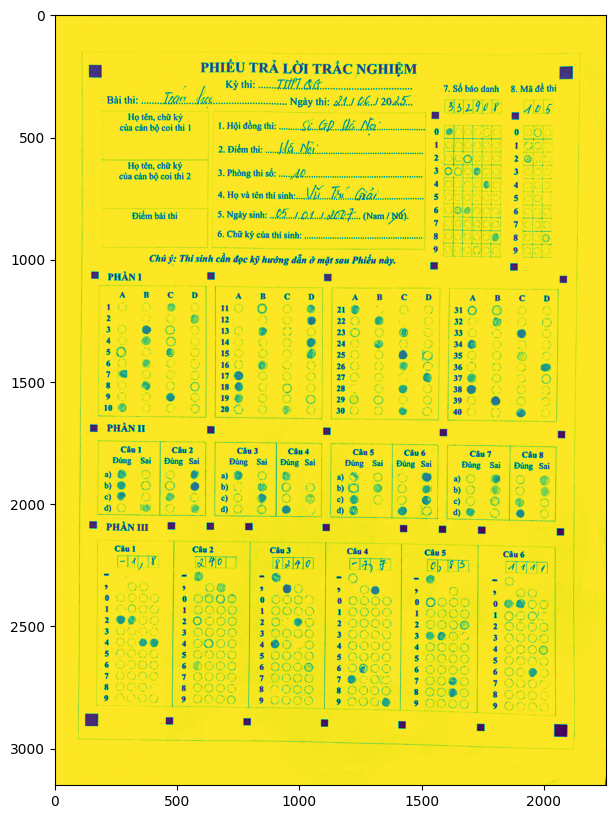

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_sheet(sheet):
    plt.figure(figsize=(20, 10))
    plt.imshow(sheet)
    plt.show()
    
img = cv2.imread("data/Trainning_SET/Images/IMG_1581_iter_0.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_sheet(gray)

## Noise reduction

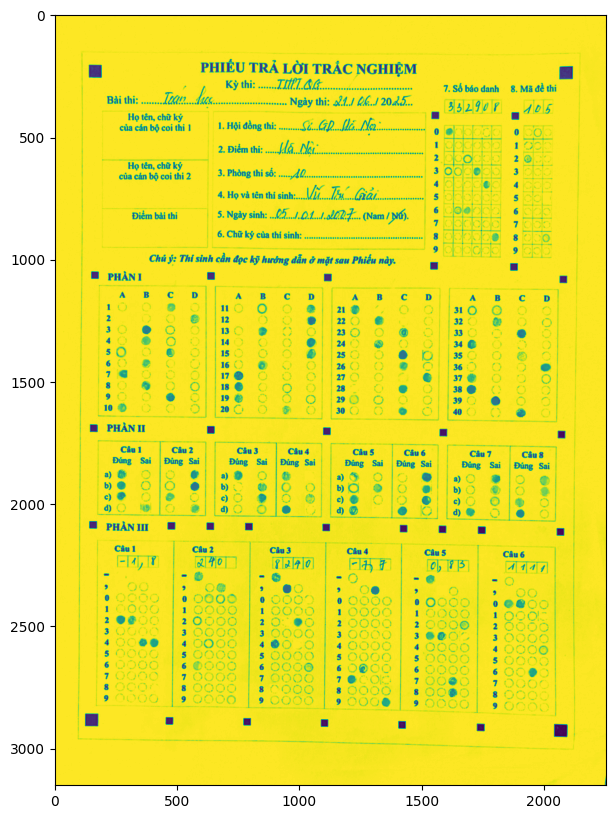

In [3]:
# Apply Gaussian Blur
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# Alternatively, apply Median Blur
# blurred = cv2.medianBlur(gray, 5)
show_sheet(blurred)

## Edge cutting

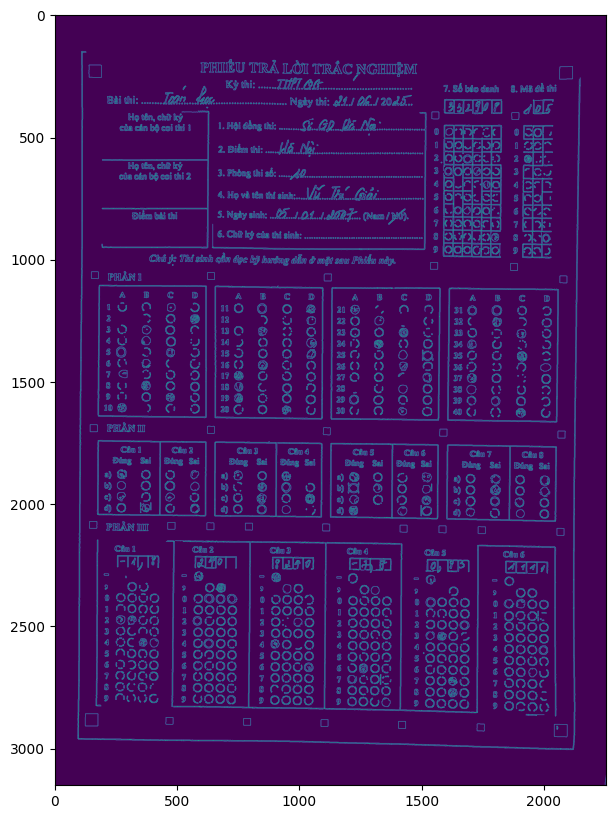

In [4]:
edges = cv2.Canny(blurred, threshold1=20, threshold2=100)
show_sheet(edges)

##  Identify the Type of Fiducial Marks

+ Squares or Rectangles

## Find Contours

In [5]:
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [6]:
len(contours)

3120

## Filter Contours to Find Squares

+ Shape: Must approximate to a square (4 sides).
+ Size: Should be within expected size ranges.
+ Aspect Ratio: Should be close to 1 for squares.

In [7]:
squares = []

for cnt in contours:
    # Approximate the contour to a polygon
    epsilon = 0.02 * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    
    # Check if the approximated contour has 4 points
    if len(approx) == 4:
        # Compute the bounding box and aspect ratio
        x, y, w, h = cv2.boundingRect(approx)
        aspect_ratio = w / float(h)
        
        # Define criteria for squares (adjust thresholds as needed)
        if 0.9 < aspect_ratio < 1.1 and 25 < w < 200:
            squares.append(approx)

In [8]:
len(squares)

31

## Select Fiducial Marks

In [9]:
def sort_fiducials(squares):
    # Calculate the center point of each square
    centers = []
    for sq in squares:
        M = cv2.moments(sq)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centers.append((cX, cY))
    
    # Sort squares based on their y-coordinate to separate top and bottom
    sorted_centers = sorted(centers, key=lambda x: x[1])
    top = sorted(sorted_centers[:2], key=lambda x: x[0])  # Left and Right Top
    bottom = sorted(sorted_centers[2:], key=lambda x: x[0])  # Left and Right Bottom
    
    return top + bottom

if len(squares) >= 4:
    fiducials = sort_fiducials(squares[:31])  # Take first four squares
else:
    print("Not enough fiducial marks detected.")
    # Handle error accordingly

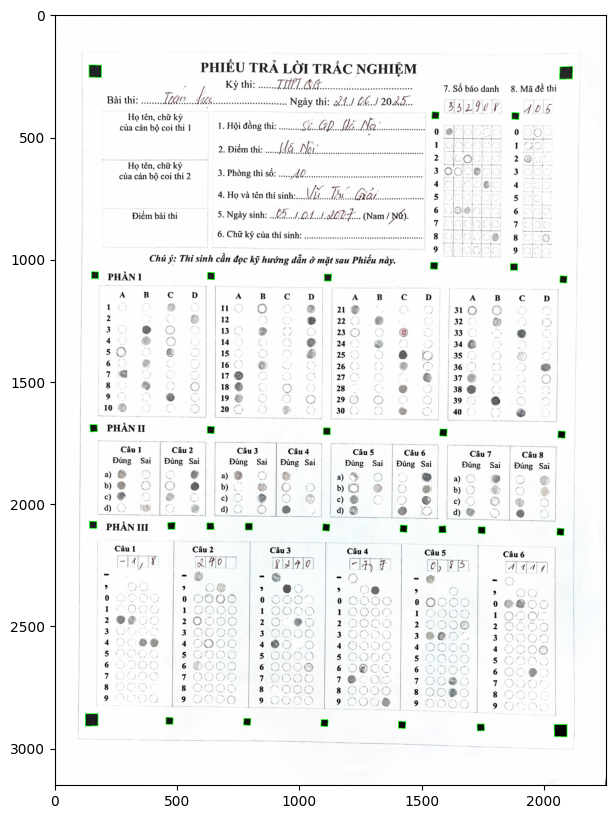

In [10]:
tmp_img = img.copy()
for sq in squares[:31]:
    cv2.drawContours(tmp_img, [sq], -1, (0, 255, 0), 2)

show_sheet(tmp_img)

## Binarization

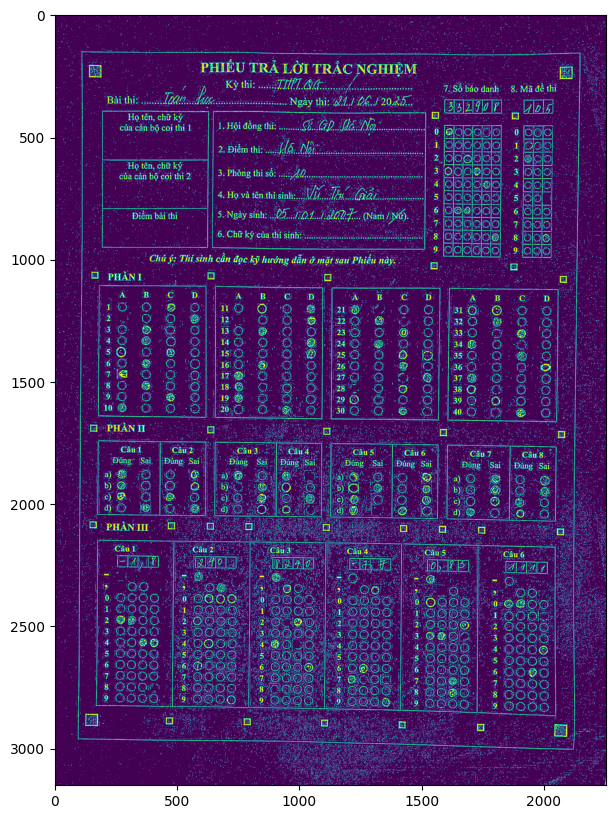

In [11]:
# Adaptive Thresholding
binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)

# Alternatively, Otsu's Thresholding
# _, binary = cv2.threshold(warped, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
show_sheet(binary)

## Morphological Operations

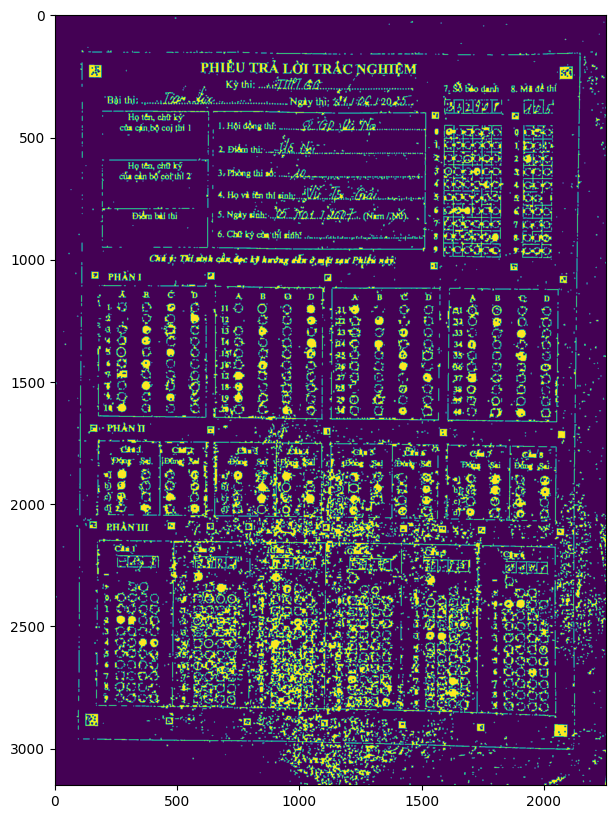

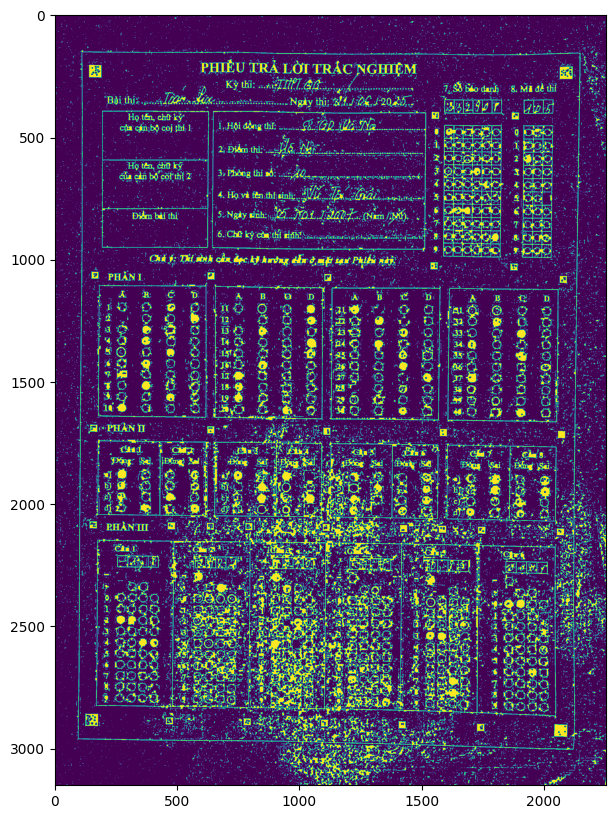

In [12]:
# Define a kernel for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

# Perform closing to fill small gaps
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

# Perform opening to remove small noises
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=1)

show_sheet(opened)
show_sheet(closed)

# Contours pipeline 

In [13]:
def show_sheet(sheet):
    plt.figure(figsize=(20, 10))
    plt.imshow(sheet)
    plt.show()

def find_contour(image_name):
    img = cv2.imread(image_name)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, threshold1=0, threshold2=100)
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    squares = []

    for cnt in contours:
        # Approximate the contour to a polygon
        epsilon = 0.02 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        
        # Check if the approximated contour has 4 points
        if len(approx) == 4:
            # Compute the bounding box and aspect ratio
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            
            # Define criteria for squares (adjust thresholds as needed)
            if 0.9 < aspect_ratio < 1.1 and 20 < w < 200:
                squares.append(approx) 
    def sort_fiducials(squares):
        # Calculate the center point of each square
        centers = []
        for sq in squares:
            M = cv2.moments(sq)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                centers.append((cX, cY))
        
        # Sort squares based on their y-coordinate to separate top and bottom
        sorted_centers = sorted(centers, key=lambda x: x[1])
        top = sorted(sorted_centers[:2], key=lambda x: x[0])  # Left and Right Top
        bottom = sorted(sorted_centers[2:], key=lambda x: x[0])  # Left and Right Bottom
        
        return top + bottom
    if len(squares) <31:
        print("Not enough fiducial marks detected.")
    tmp_img = img.copy()
    for sq in squares[:31]:
        cv2.drawContours(tmp_img, [sq], -1, (0, 255, 0), 2)
    return tmp_img,sq

In [14]:
render, sq = find_contour("data/Trainning_SET/Images/IMG_3958_iter_259.jpg")

Not enough fiducial marks detected.


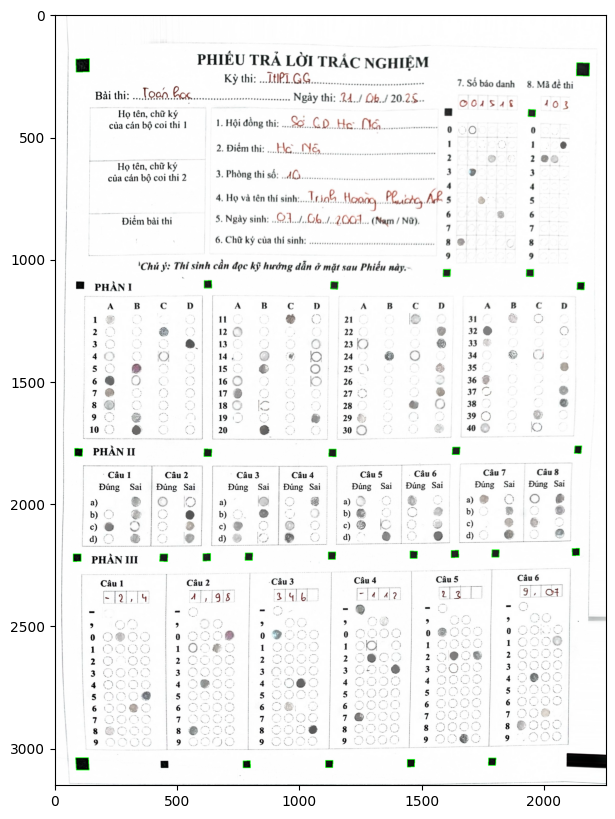

In [15]:
show_sheet(render)

There are still some missing detecting

## Find pivot

We will using a good predicting to get its square contours, then expanding it to get pivots

In [16]:
render, small_pivot = find_contour("data/Trainning_SET/Images/IMG_1581_iter_1.jpg")

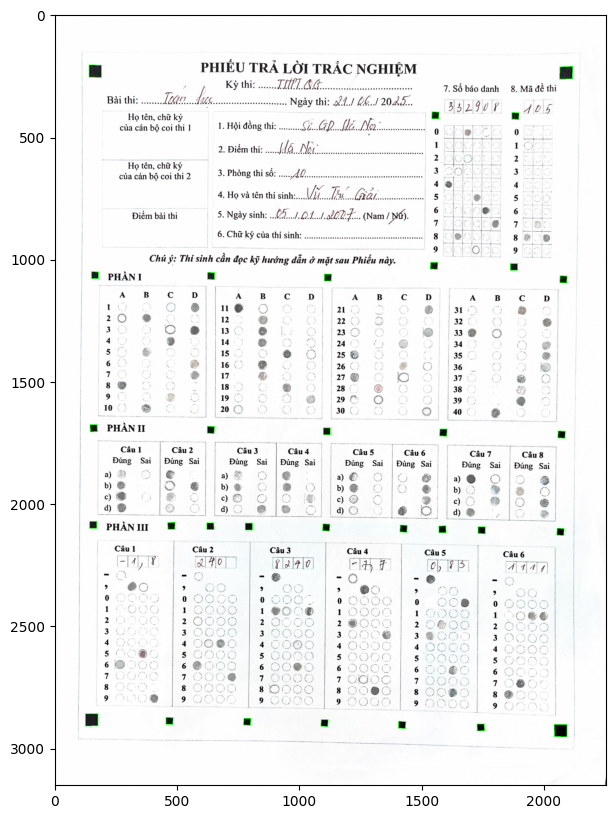

In [17]:
show_sheet(render)

This seem to be true